**Prática de Segmentação de imagens**

In [108]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import time
import operator

BLACK = 0
MEDIUM_GRAY = 127
WHITE = 255

MAX = 256

def readImage(path):
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE)

def getLocalTime() -> str:
    named_tuple = time.localtime() # get struct_time
    return time.strftime("%d/%m/%Y, %H:%M:%S", named_tuple)


def showImage(image, cmap = 'gray') -> None:
    showImages((image), cmap=cmap)


def showImages(images, cmap = 'gray') -> None:
    _, axs = plt.subplots(nrows=1, ncols=len(images))

    for i in range(len(images)):
        axs[i].imshow(images[i], cmap = cmap, vmin = BLACK, vmax = WHITE)

    plt.tight_layout()

def saveImage(image, filename = 'result', cmap = 'gray', mode = 'sync') -> None:    
    ax = plt.subplots()[1]
    ax.imshow(image, cmap = cmap, vmin = BLACK, vmax = WHITE)
    plt.savefig(filename, bbox_inches = 'tight', pad_inches = 0)

    if mode == 'sync':
        plt.show()


def getFrequency(image, max = 256):
    copy = np.array(image)
    unique, counts = np.unique(copy, return_counts=True)
    freqMtx = np.asarray((unique, counts)).T
    
    freq = [0] * max
    for key, value in freqMtx:
        freq[int(key)] = int(value)
    
    return freq


def getHistMedia(freq, max = 256):
    media = 0
    for i in range(len(freq)):
        media += i * freq[i]
    
    return media / np.array(freq).sum()


def getProbabilities(image, max = 256):
    height, width = image.shape
    
    freq = getFrequency(image, max)
    prob = np.zeros(max)

    for i in range(max):
        prob[i] = freq[i] / (height * width)
        
    return prob

def plotHistograma(image, title = '', max = 256):
    ax = plt.subplots()[1]
    hist = getProbabilities(image, max)
    
    plt.title(title)
    plt.xlabel('Tom de cinza')
    plt.ylabel('Probabilidade')

    ax.bar(range(max), hist)
    plt.show()

def binarify(image, condition):
    result = np.zeros(image.shape)
    height, width = image.shape
    for i in range(0, height):
        for j in range(0, width):
            result[i][j] = condition(image[i][j]) * 255
            
    return result

def filtroMedia(image, v):
    pad = int(v / 2) 

    height, width = image.shape
    result = np.array(image)
    imageWithPad = np.pad(image, ((pad, pad), (pad, pad)), mode='constant', constant_values=(0))

    for i in range(pad, height + pad):
        for j in range(pad, width + pad):
            iInfLimit = i - pad
            iSupLimit = i + pad + 1

            jInfLimit = j - pad
            jSupLimit = j + pad + 1

            block = imageWithPad[iInfLimit:iSupLimit, jInfLimit:jSupLimit]
            result[i - pad][j - pad] = block.sum() / v ** 2

    return result

1) Faça a plotagem do histograma da imagem, observando o histograma, escolha um valor para definir um threshold

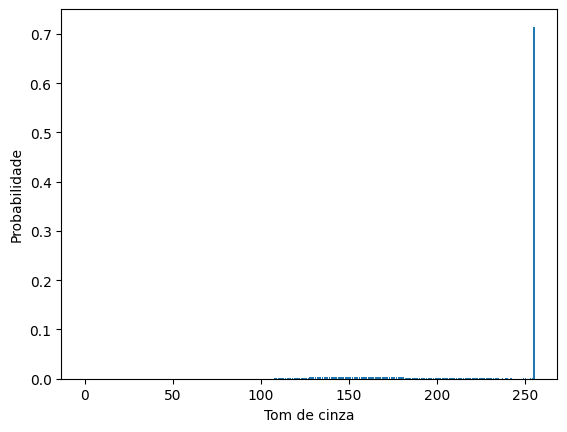

Threshold:  228.95235185185186


In [85]:
img1 = cv2.imread("insitu107595.jpg", cv2.IMREAD_GRAYSCALE)

# plt.imshow(img1, cmap='gray', vmin=0, vmax=255)
plotHistograma(img1)
thr = np.average(img1)

print('Threshold: ', thr)


2)	Segmentação utilizando a técnica de Threshold Adaptativo (implementar o algortimo). Faça a aplicação do Threshold com e sem suavização prévia

Threshold
(imagem original)  205 ;
(imagem suavizada)  207 ;


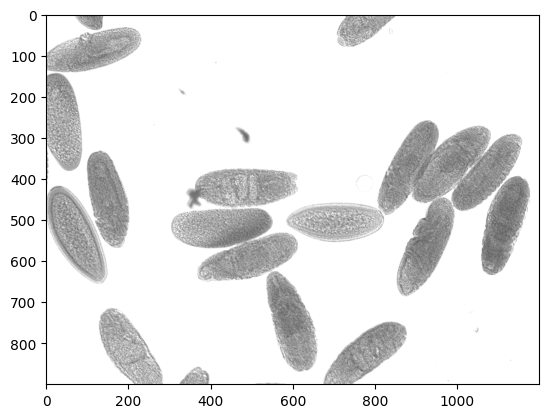

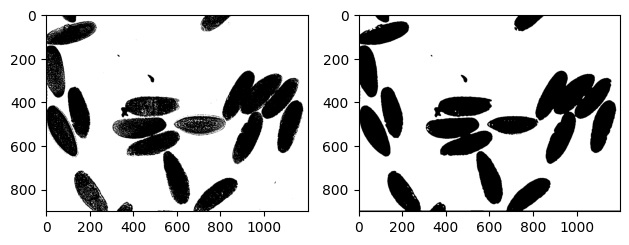

In [86]:
imgO = cv2.imread("insitu107595.jpg", cv2.IMREAD_GRAYSCALE)
imgS = filtroMedia(imgO, 7)

plt.imshow(imgO, cmap='gray', vmin=0, vmax=255)

def limiarizacaoAdaptativa(image, deltaT = 5, L = MAX):
    freq = getFrequency(image)
    
    thr = int(np.floor(np.average(image)) + 1)
    lastVal = thr
    
    while True:      
        g1 = freq[0:thr]
        g2 = [0] * thr + freq[thr:L]
        
        mG1 = getHistMedia(g1) if len(g1) > 0 else 0
        mG2 = getHistMedia(g2) if len(g2) > 0 else 0
        
        lastVal = thr
        thr = int(np.floor((mG1 + mG2) / 2) + 1)
        
        if abs(mG2 - mG1) <= deltaT or lastVal == thr:
            break
        
    return thr
        
thrO = limiarizacaoAdaptativa(imgO)
thrS = limiarizacaoAdaptativa(imgS)

print('Threshold')
print('(imagem original) ', thrO, ';')
print('(imagem suavizada) ', thrS, ';')

showImages(
    (
        binarify(imgO, lambda c: c > thrO),
        binarify(imgS, lambda c: c > thrS)
    ),
)

3) Segmentação utilizando a técnica de Otsu (implementar) . Faça a aplicação do Threshold com e sem suavização prévia. Mostre um gráfico com o histograma juntamente com a variância entre classes (Exemplo: https://en.wikipedia.org/wiki/File:Otsu%27s_Method_Visualization.gif)

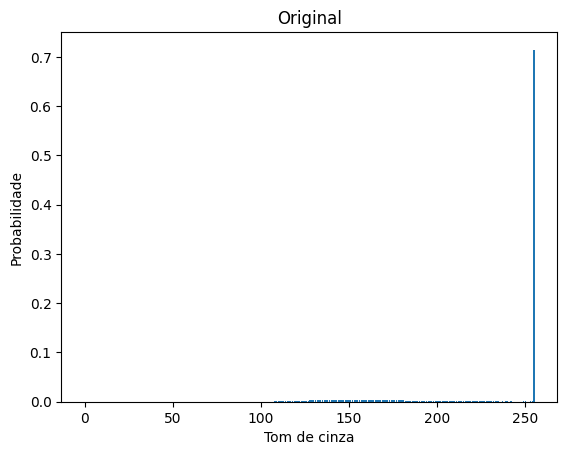

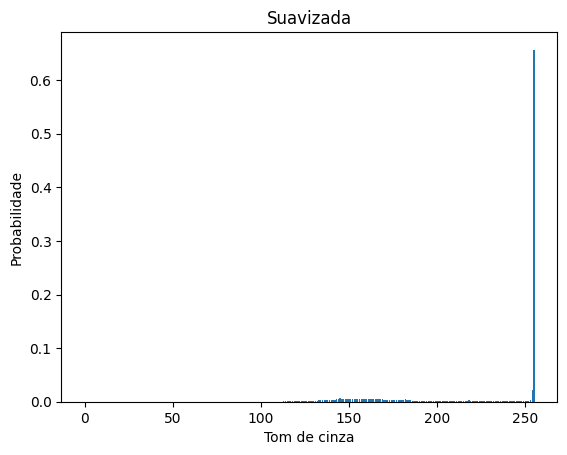

Maior Variancia =  1816.2871072703106 ;
Threshold imagem original =  233.37602674594515 ;

Maior Variancia =  1742.1594775746817 ;
Threshold imagem suavizada =  234.58788510430088 ;


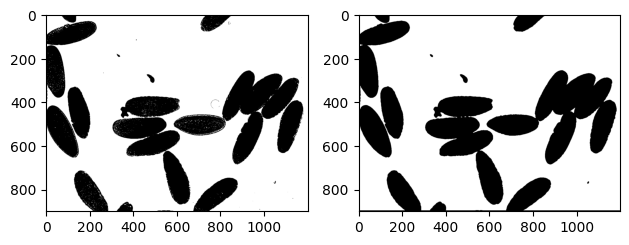

In [95]:
imgO = cv2.imread("insitu107595.jpg", cv2.IMREAD_GRAYSCALE)
imgS = filtroMedia(imgO, 7)

# plt.imshow(img1, cmap='gray', vmin=0, vmax=255)

def limiarizacaoOtsu(image, L = MAX):
    variancy = np.var(image)
    probs = np.array(getProbabilities(image))
    
    maior = 0
    for k in range(L):
        thr = k + 1
        
        g1 = probs[0:thr]
        g2 = probs[thr:]
        
        P1 = g1.sum()
        P2 = 1 - P1
        
        m1 = (np.arange(thr) * g1).sum()
        m2 = (np.arange(thr, L) * g2).sum()
                
        m1 = m1 / P1 if P1 > 0 else m1
        m2 = m2 / P2 if P2 > 0 else m2
        sigmaB = P1 * P2 * ((m1 - m2) ** 2)
        
        if maior < sigmaB:
            maior = sigmaB
            
    print('Maior Variancia = ', maior, ';')
    
    return (maior / variancy) * 255

plotHistograma(imgO, title = 'Original')
plotHistograma(imgS, title = 'Suavizada')

thrO = limiarizacaoOtsu(imgO)
print('Threshold imagem original = ', thrO, ';\n')

thrS = limiarizacaoOtsu(imgS)
print('Threshold imagem suavizada = ', thrS, ';')

showImages(
    (
        binarify(imgO, lambda c: c > thrO),
        binarify(imgS, lambda c: c > thrS)
    ),
)

In [ ]:
4)	Aplique o Otsu para a imagem HE.jpg, madrill.tiff e  Lenna.jpg (use antes a conversão da imagem para tons de cinza)

Maior Variancia =  2413.605251767149 ;
Threshold imagem (HE.jpg) =  182.7543494560629 ;

Maior Variancia =  1220.4431611586654 ;
Threshold imagem (madrill.tiff) =  173.82573916788863 ;

Maior Variancia =  2589.939364719894 ;
Threshold imagem (Lenna.jpg) =  179.00763103478366 ;



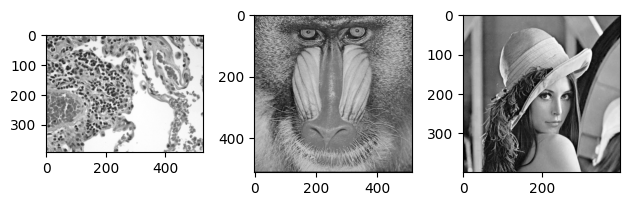

In [115]:
imgs = {
    'he': cv2.imread("HE.jpg", cv2.IMREAD_GRAYSCALE),
    'madrill': cv2.imread("madrill.tiff", cv2.IMREAD_GRAYSCALE),
    'lenna': cv2.imread("Lenna.jpg", cv2.IMREAD_GRAYSCALE),
}

thr0 = limiarizacaoOtsu(imgs['he'])
print('Threshold imagem (HE.jpg) = ', thr0, ';\n')

thr1 = limiarizacaoOtsu(imgs['madrill'])
print('Threshold imagem (madrill.tiff) = ', thr1, ';\n')

thr2 = limiarizacaoOtsu(imgs['lenna'])
print('Threshold imagem (Lenna.jpg) = ', thr2, ';\n')

showImages(list(imgs.values()))

showImages(
    (
        binarify(imgs['he'], lambda c: c > thr0),
        binarify(imgs['madrill'], lambda c: c > thr1),
        binarify(imgs['lenna'], lambda c: c > thr2)
    ),
)